In [1]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

2022-11-06 15:37:11.597084: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


This is notebook for Kaggle CIFAR-10 competition. Its main goal is to build a multiclass classifier. Our dataset is bunch of images of diffrent object that do not overlap. There is only one object on each image.

## Data exploration

On this stage, let's create a function that will get path to data and data labels and return list combinations of file - label.

Also further create function, that prepare data for Tensorflow dataset.

In [3]:
# structre out data
def load_data(dataset_path, labels):
    """Match features and labels from the data source

    Args:
        dataset_path (list of str): path to dataset
        labels (pd.DataFrame): dataset with labeled target sorted by filename

    Returns:
        X (np.ndarray): array of path to images
        y (np.ndarray): array with labeled target
    """    
    
    file_names = sorted(glob.glob(f'{dataset_path}/*.png'))
    file_names.sort(key=lambda f: int(re.sub('\D', '', f)))     # sort filenames by it numbers
    
    X = np.array(file_names)
    y = labels['label'].to_numpy()
    
    return X, y

In [4]:
# init folder, where our data is stored
train_path = 'train/'
test_path = 'test/'
# crete dir to store model parametrs
os.makedirs('model', exist_ok=True)
# read file with labeled target
trainLabels = pd.read_csv('trainLabels.csv')

# load data
filenames, labels = load_data(train_path, trainLabels)

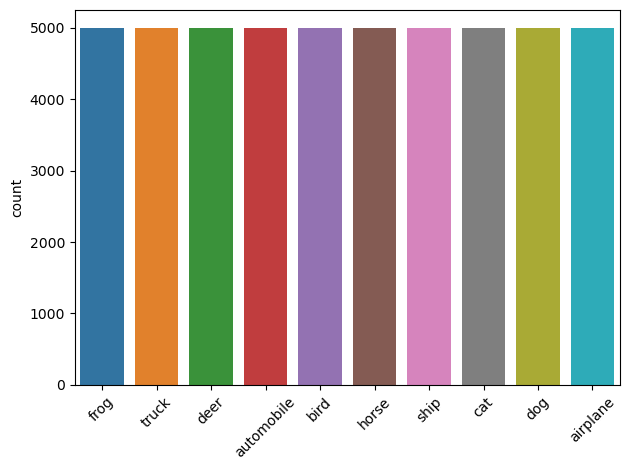

In [118]:
# plot classes distribution
sns.countplot(x=labels)
plt.xticks(rotation=45)
plt.tight_layout()

We can see that distribution of our target label is uniformal. It much simplicy our evaluation stage, where accuracy can show real perfomance of model.

Before make some data preprocession, let's build simple NN, make some Error Analysis, investigate pros and cons of model, its disadvatage. On top of this information we will make some manipulation with data and build better, more deep and more specific model.

But at fist, take a look at some data examples.

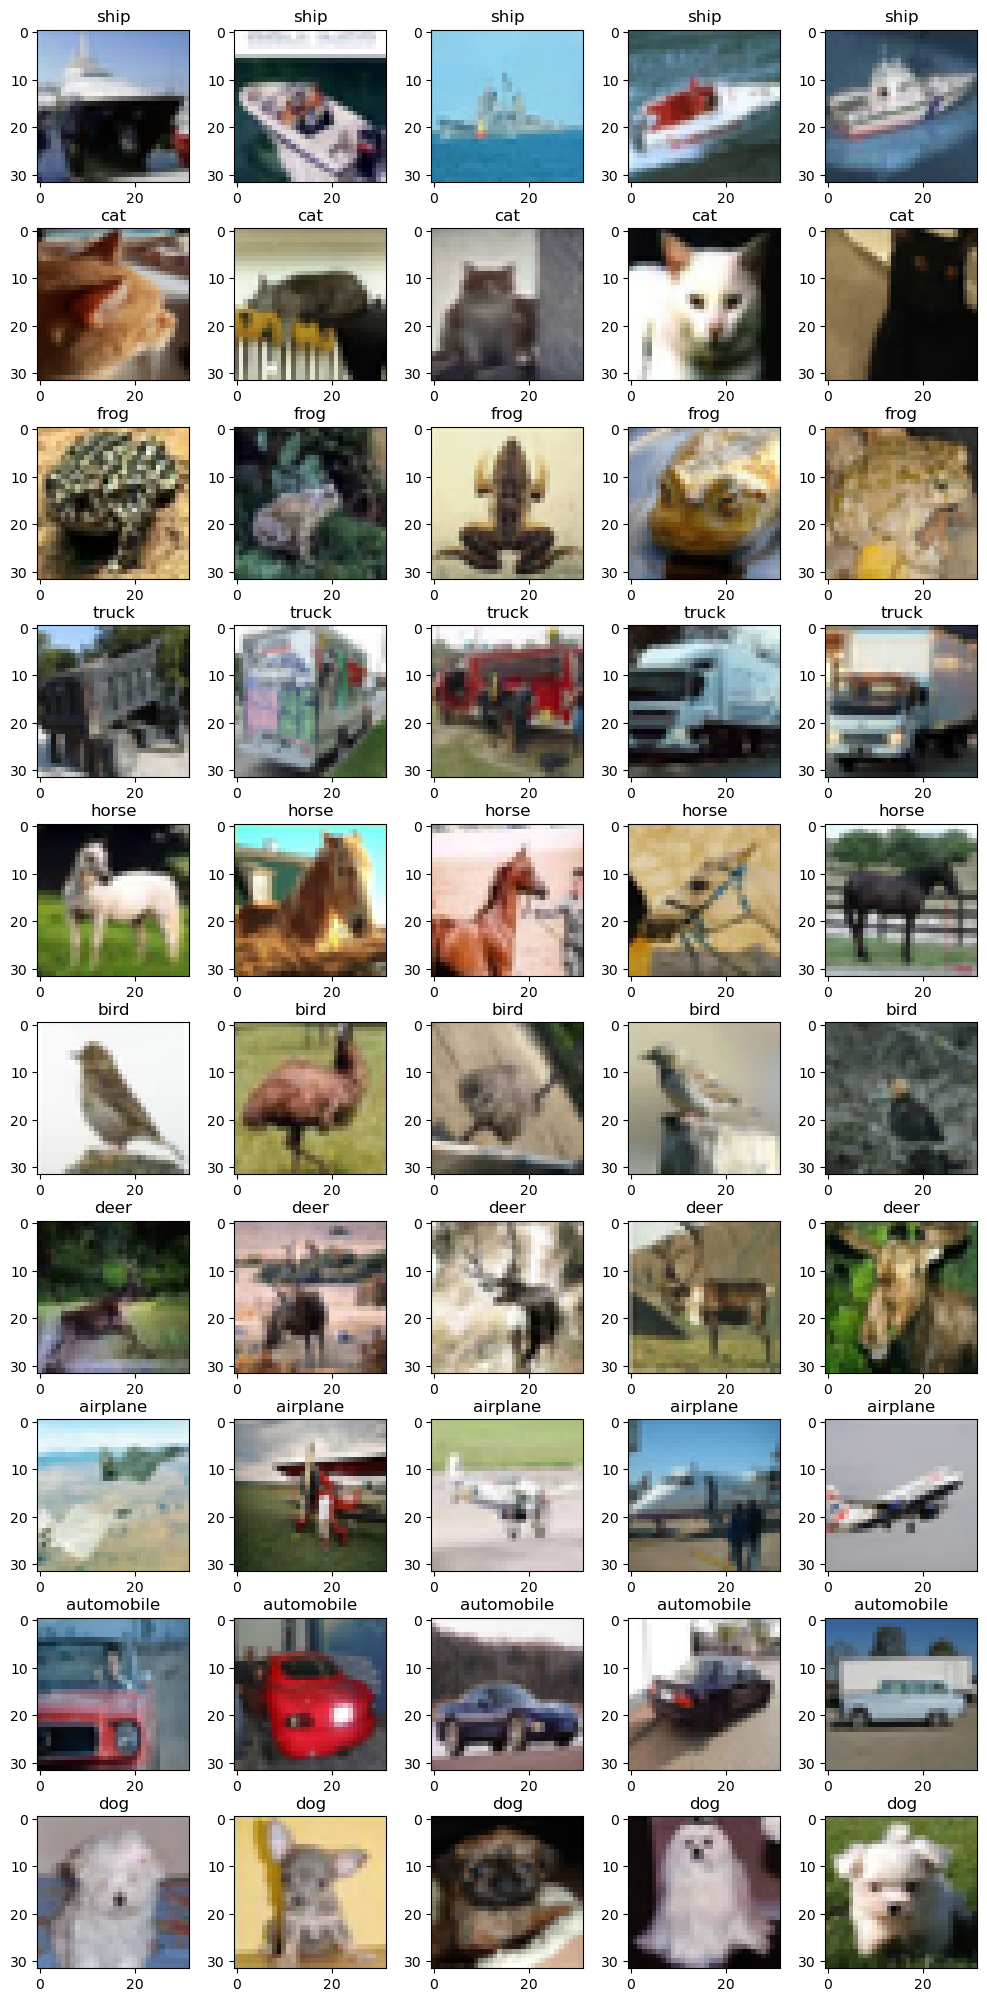

In [121]:
np.random.seed(42)

# plot some examples of each class
fig, ax = plt.subplots(10, 5, figsize=(10, 20))
for i, el in enumerate(set(labels)):
    idx = np.random.choice(np.argwhere(labels == el).flatten(), 5)
    for j in range(5):
        img = plt.imread(filenames[idx[j]])
        ax[i][j].imshow(img)
        ax[i][j].set_title(el)
    plt.tight_layout()

## First model

### Train/ dev sets
To prepare our data for model feeding, we need to restructure our data storage. In this case, each image have to be placed in folder with name of its class.
But at first we need to create this folder.

In [5]:
def create_labels_dir(labels, path):
    """Function that create folder named by target class

    Args:
        labels (np.ndarray): an array with unique labels for target
        path (str): path to place where create class-dir
    """    
    for el in labels:
        os.makedirs(f'{path}/{el}', exist_ok=True)
   
        
def move_img_to_label_dir(filenames, labels, path):
    """Distribute shuffled files to its class folder

    Args:
        filenames (np.ndarray): an array file file paths
        labels (np.ndarray): an array with label to each file
        path (_type_): path to place where class-dir is located
    """    
    
    if not filenames.shape[0]:
        return
    
    for el in set(labels):
        for fl in filenames[labels == el]:
            if os.path.exists(fl):
                os.system(f'mv {fl} {path}/{el}')

In [6]:
# creating folder with classes names in dir with training data
create_labels_dir(set(labels), 'train')
# sort and move our images by its class folder
move_img_to_label_dir(filenames, labels, 'train')

# creating TensorFlow datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory('train', image_size=(32,32), seed=42, validation_split=0.2, subset='training', batch_size=64)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory('train', image_size=(32,32), seed=42, validation_split=0.2, subset='validation', batch_size=64)

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Found 50000 files belonging to 10 classes.
Using 10000 files for validation.


### Model

Here we will build simple sequential CNN with 6 ConvLayers and 1 full connected layers. Also add some regularisation like Dropout and L2. For better perfomance, BatchNormalization and Rescaling are added. Also for preventing big overfitting let's use regularisation like Dropout and L2.

In [5]:
# Some hyperparameters for model
BATCH_SIZE = 64
EPOCHS = 100
HEIGHT = 32
WEIGHT = 32
L2_REG = None #0.0001
MODEL_PATH = os.path.join('model', 'model.h5')

In [55]:
def first_model(input_shape = (32, 32, 3), batch_size = 64):
    """The Function which build simple 8-layer CNN model with input Scaling and BatchNormalization of each layer

    Args:
        input_shape (tuple, optional): Desribe the shape of input images. Defaults to (32, 32, 3).
        batch_size (int, optional): Settf'{path}/{el}'up the number of batch size. Defaults to 64.

    Returns:
        model (tensorflow.python.keras.engine.functional.Functional): TensorFlow model
    """    
    
    inputs = tf.keras.Input(shape=input_shape, batch_size=batch_size)
    #X = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    
    X = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(L2_REG))(inputs)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    
    X = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(L2_REG))(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2))(X)
    
    X = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(L2_REG))(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    
    X = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(L2_REG))(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2))(X)
    
    X = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(L2_REG))(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    
    X = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(L2_REG))(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(2,2))(X)
    
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(L2_REG))(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    
    outputs = tf.keras.layers.Dense(units=10, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [56]:
# build model
model = first_model()
# compile model using Adam optimizer and SparseCategoricalCrossentropy as loss
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 32, 32, 3)]         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (64, 32, 32, 32)          896       
_________________________________________________________________
batch_normalization_28 (Batc (64, 32, 32, 32)          128       
_________________________________________________________________
conv2d_25 (Conv2D)           (64, 32, 32, 32)          9248      
_________________________________________________________________
batch_normalization_29 (Batc (64, 32, 32, 32)          128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (64, 16, 16, 32)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (64, 16, 16, 64)          18496 

In [29]:
# add ModelCheckpoint to callback, so we can save and use the best model later
callbacks = [ModelCheckpoint(MODEL_PATH, verbose=1, save_only_best=True, monitor='val_accuracy', mode='max')]

# train our model with 100 epochs
history = model.fit(train_ds, epochs=EPOCHS, verbose=2, batch_size=BATCH_SIZE, validation_data=valid_ds, callbacks=callbacks)

Epoch 1/100
625/625 - 15s - loss: 6.1087 - accuracy: 0.4936 - val_loss: 2.9088 - val_accuracy: 0.5268

Epoch 00001: saving model to model/model.h5
Epoch 2/100
625/625 - 13s - loss: 2.1678 - accuracy: 0.6442 - val_loss: 2.0664 - val_accuracy: 0.5968

Epoch 00002: saving model to model/model.h5
Epoch 3/100
625/625 - 12s - loss: 1.7751 - accuracy: 0.6805 - val_loss: 1.8922 - val_accuracy: 0.6399

Epoch 00003: saving model to model/model.h5
Epoch 4/100
625/625 - 13s - loss: 1.7156 - accuracy: 0.6979 - val_loss: 1.8379 - val_accuracy: 0.6453

Epoch 00004: saving model to model/model.h5
Epoch 5/100
625/625 - 13s - loss: 1.6956 - accuracy: 0.7103 - val_loss: 1.7664 - val_accuracy: 0.6853

Epoch 00005: saving model to model/model.h5
Epoch 6/100
625/625 - 12s - loss: 1.6697 - accuracy: 0.7196 - val_loss: 2.0175 - val_accuracy: 0.6060

Epoch 00006: saving model to model/model.h5
Epoch 7/100
625/625 - 12s - loss: 1.6490 - accuracy: 0.7230 - val_loss: 1.7787 - val_accuracy: 0.6596

Epoch 00007: sa

### Model Analysis

On this stage we are going to explore some model metrics to evaluate its perfomance and make some conlusion how to improve model in future.

At first we are going to look at Learning and Loss curves.

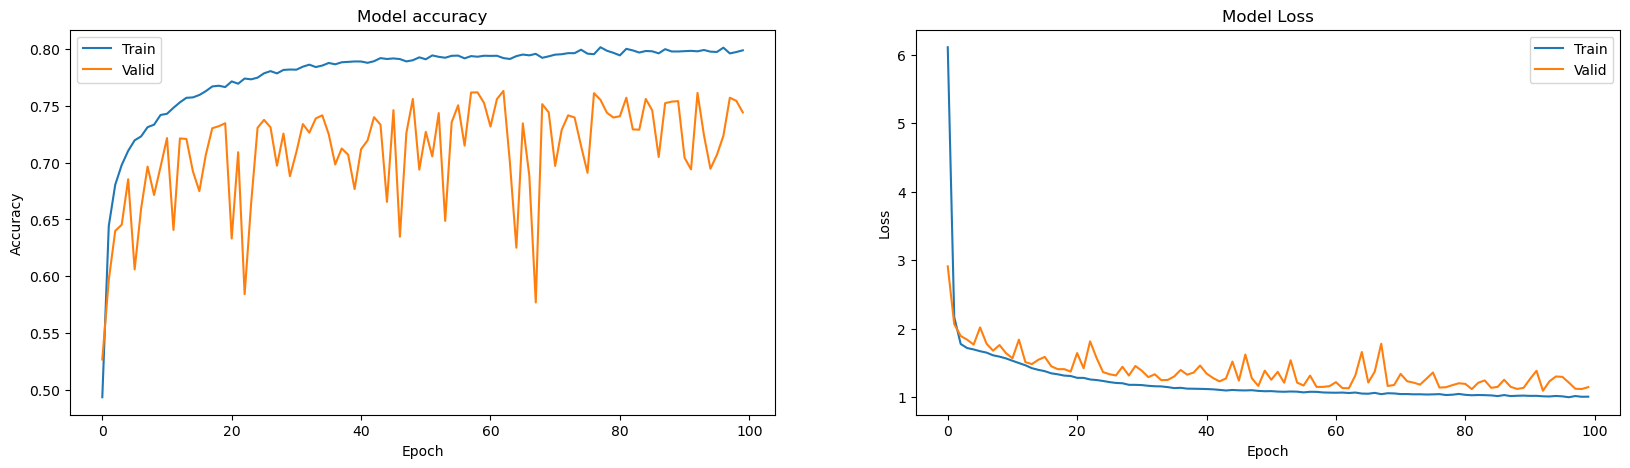

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot training & validation learning curve
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Valid'])

# Plot training & validation loss scores
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Valid'])

We can inspect that train and valid scores and losses are pretty close - so overfit is absent. But <b>too big Dropout regulazatoin</b> coefficient made curve more stohastic and unstable. However, there is obvious hight bias, as model reach only 0.755 accuracy score, while human-level in near 1. Usually accuracy is not very confident metric for classification, but in our case, where classes spread similary, its OK.

In case, to solve hight bias problem we can <b>increase model comlexity and deepness</b>, <b>reduce regularisation</b>, <b>use some big pretrained model</b>. We can also <b>get more data by doing data augmentation</b>, but it does not effect hight bias problem. Nevertheless, it can help our more complex model to perfome better.

Now it's time to take a look at places where our model making mistake. For this purpose let's build Confusion Matrix.

2022-10-21 13:39:12.292676: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.


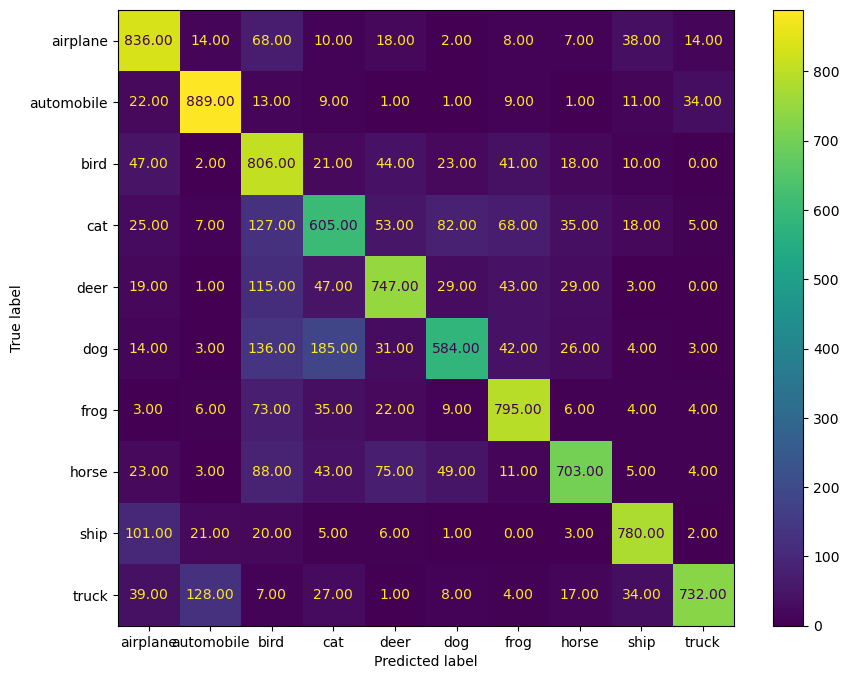

In [10]:
# load the best model
model = tf.keras.models.load_model(MODEL_PATH)

# our ds is shuffeling on every iter, so we need to extract stable examples
valid_X = []
valid_y = []
for x, y in valid_ds:
    valid_X.append(x)
    valid_y.append(y)
        
valid_X = tf.concat(valid_X, axis=0)
valid_y = tf.concat(valid_y, axis=0)    # true values

# make model prediction
pred = np.argmax(model.predict(valid_X), axis=1)

# interpret our model output, I made it hadly in another place by just ploting images
label = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# plot confusion matri, normalize='true'x
confusion_mtx = confusion_matrix(valid_y, pred)
disp = ConfusionMatrixDisplay(confusion_mtx, display_labels=label.values())
fig, ax = plt.subplots(figsize=(10,8))
disp.plot(values_format='.2f', ax=ax)

Confusion matrix gives very powerful information about our model. So model have good undetstanding about 'airplane', 'automobile', it can successfully regocnize them in ~75% of cases. Another class also show satistificated results, except for 'cat' and 'dog'.

We can notice that it is <b>hard for model to clearly classified cats</b>, it missclass them with bunch of available classes, <b>expecial 'bird'</b>. A bit another problem with 'dog', here two main subproblems: <b>dog-cat</b> and <b>dog-bird missclass</b>.

We have to:
- compare cat - bird classes
- compare dog - bird classes
- compare dog - cat classes

As we have very balanced between each class for further analysis it will be better to use ROC-AUC curve rather then Precision-Recall curve.

ROC AUC score: 0.860739635414529


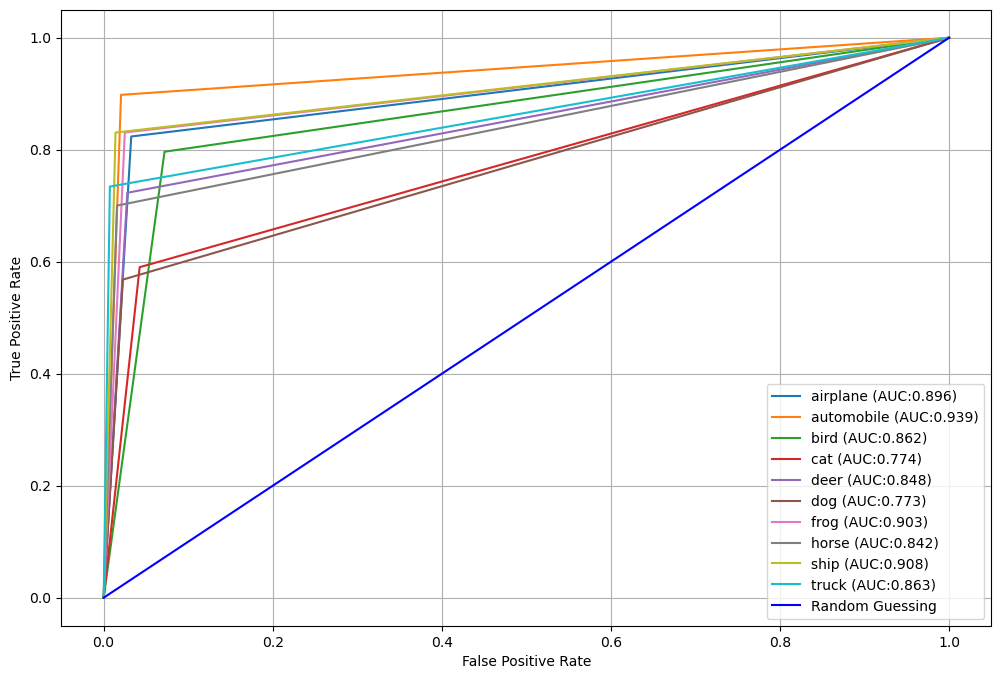

In [9]:
# set plot figure size
fig, ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    # prepare label for ovr compare
    lb = LabelBinarizer()
    y_test = lb.fit_transform(y_test)
    y_pred = lb.transform(y_pred)

    # plot roc curves ovr
    for (idx, l) in enumerate(label.values()):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        ax.plot(fpr, tpr, label=f'{l} (AUC:{auc(fpr, tpr):0.3f})')
    
    # plot baseline roc 
    ax.plot(fpr, fpr, 'b-', label='Random Guessing')
    
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(valid_y, pred))

ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid()
plt.show()

Here we can inspect simillar ideas. If we will build classifier OneVsRest, 'vat' and 'dog' classifier is perfome bad. Also there are a lot of space to improve even 'good' classifiers.

### Error Analysis
So, to improve our model we are going to do some error analysis. We will take a look at bunch of images that was misclassificated by model and try to get around it purpuse. Goal is to find solution to each problem of missclassification.

In [11]:
# find image index on which mistake was been made
error_idx = np.argwhere(valid_y != pred).flatten()
print(f'We have {error_idx.shape[0]} missclasses images from {valid_y.shape[0]}')

We have 2523 missclasses images from 10000


Let's observe 3 most problem cases:
- cat - bird
- dog - bird
- dog - cat 

In [13]:
# set seed to get the same image every time
np.random.seed(42)

# fucntion to plot images to compare and understand misclassication
def plot_image_compare(class_num, missclass_num, replace=False):
    """ This function help to understand the purpose of missclassification by plotting true class examples, error class examples and missclassed examples.

    Args:
        class_num (int): idex of class in model labels which is observed
        missclass_num (int): index of class in model labels which incorrectly classified (should be class_num) 
        replace (bool, optional): If True enable to plot not unique examples. Defaults to False.
    """    
    
    # plot some examples
    def _plot(idx, num_el, figsize=(20,5), replace=False):
        fig = plt.figure(figsize=figsize)
        if idx.shape[0] < num_el:   # check if we can plot only unique images
            replace = True
        for i, el in enumerate(np.random.choice(idx, num_el, replace=replace)):
            fig.add_subplot(3, 10, i + 1)
            plt.imshow(valid_X[el].numpy().astype(np.uint8))
            valid_label = label[valid_y[el].numpy()]     # true label
            pred_label = label[pred[el]]    # pred label
            plt.title(f'{valid_label}/{pred_label}')
            
        plt.tight_layout()
        plt.show()   
        
    # find index error per class
    class_error_idx = np.argwhere((valid_y == class_num) & (pred == missclass_num)).flatten()
    class_corr_idx = np.argwhere((valid_y == class_num) & (valid_y == pred)).flatten()
    missclass_idx = np.argwhere((valid_y == missclass_num) & (valid_y == pred)).flatten()

    print('The image title has such structure: TRUE label/PRED label')

    # plot images that was missclassed
    _plot(class_error_idx, 30, (20,7))
    
    # plot images that was classified correctly
    _plot(class_corr_idx, 20)

    # plot examples of class of missclass
    _plot(missclass_idx, 20)

The image title has such structure: TRUE label/PRED label


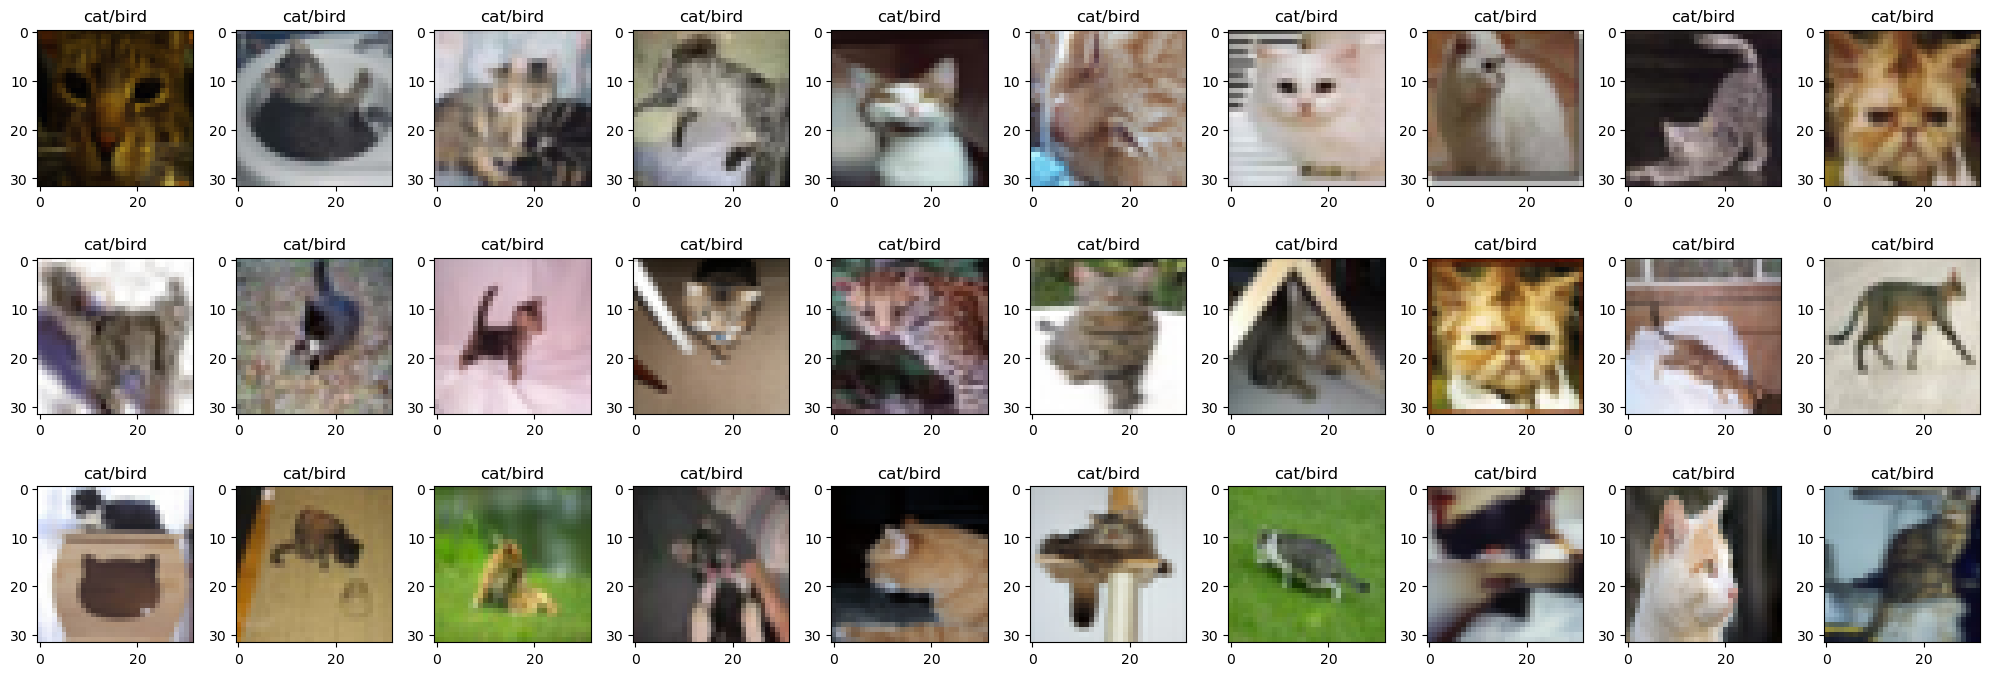

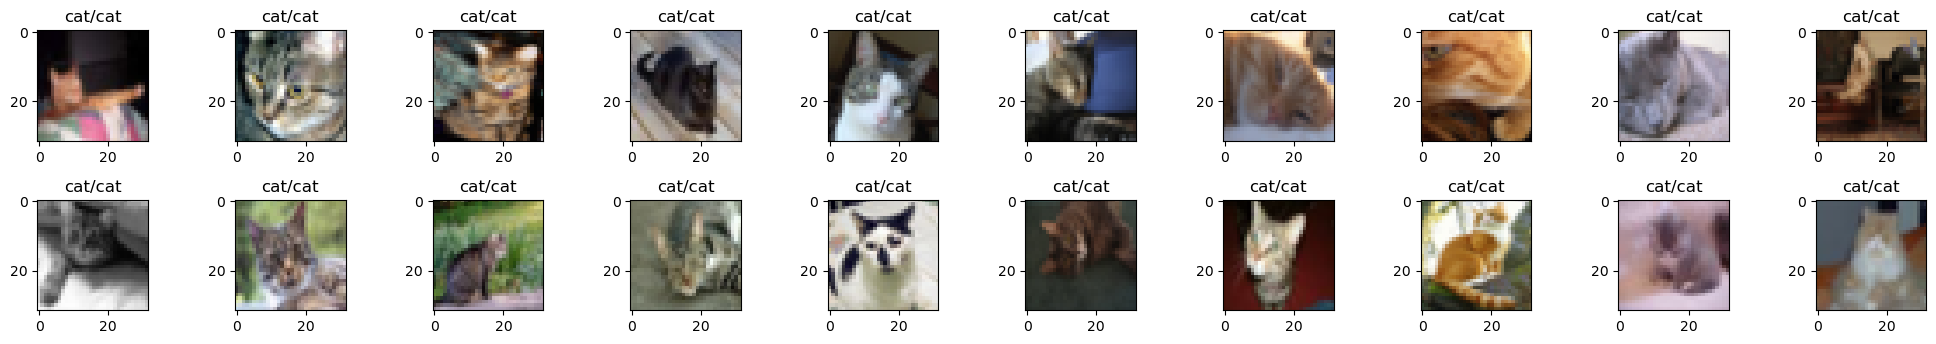

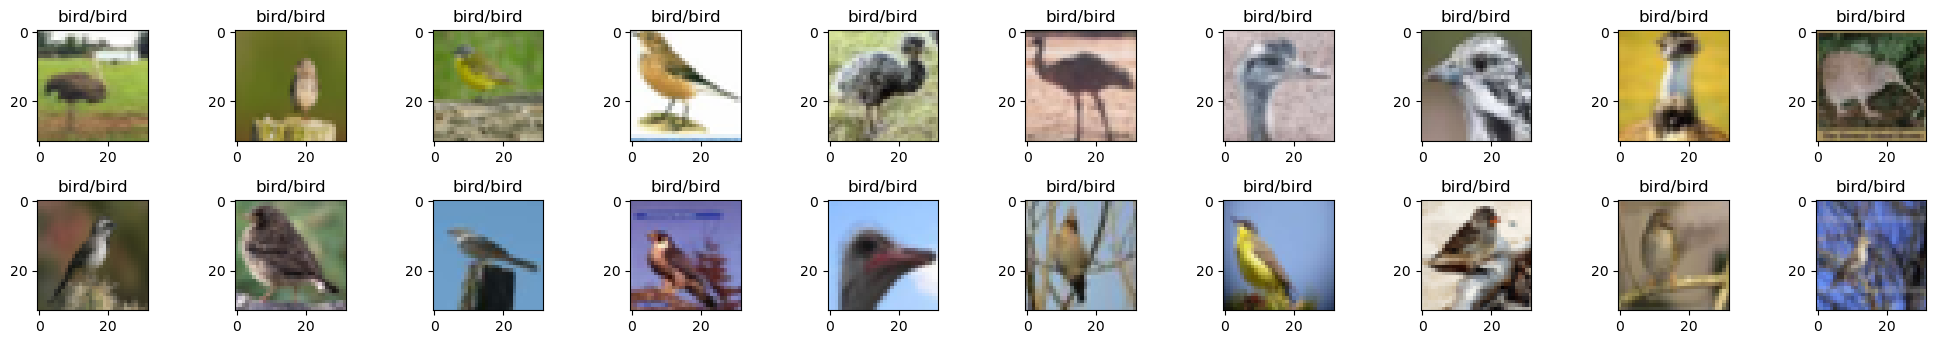

In [14]:
# observe cat-bird missclass
plot_image_compare(3, 2)

It is hard to understand clearly why model made such prediction, no clear error algorithm is observed. The idea, that can solve this problem is <b>to build more complex model</b> which can extract more userful features. Also <b>adding more units to Full Connected layers or more FC layers</b> can also help to extract more useful features.

The image title has such structure: TRUE label/PRED label


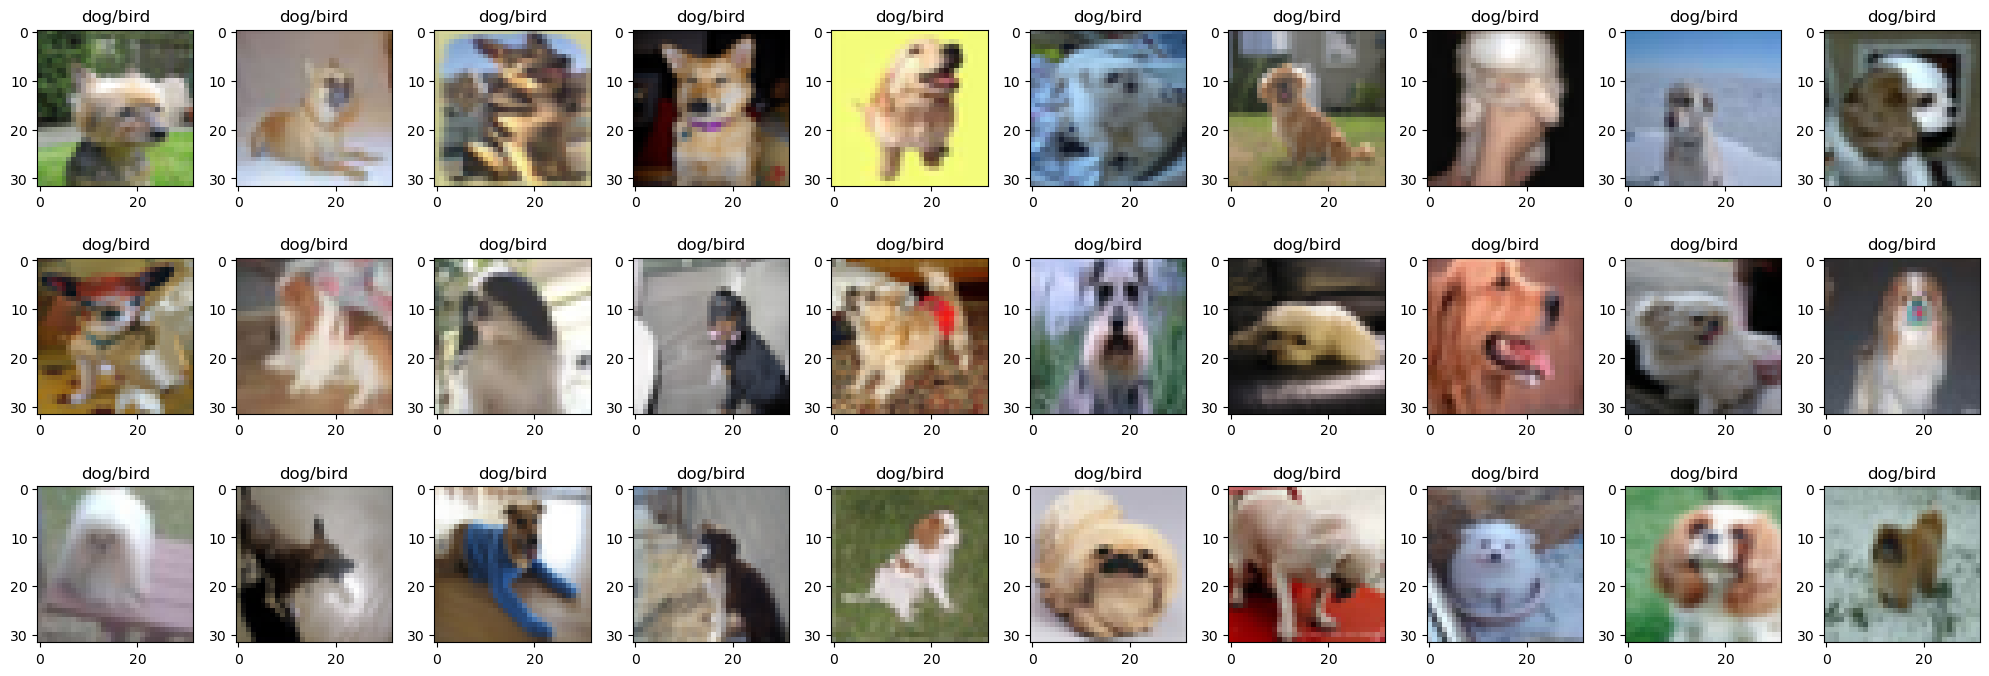

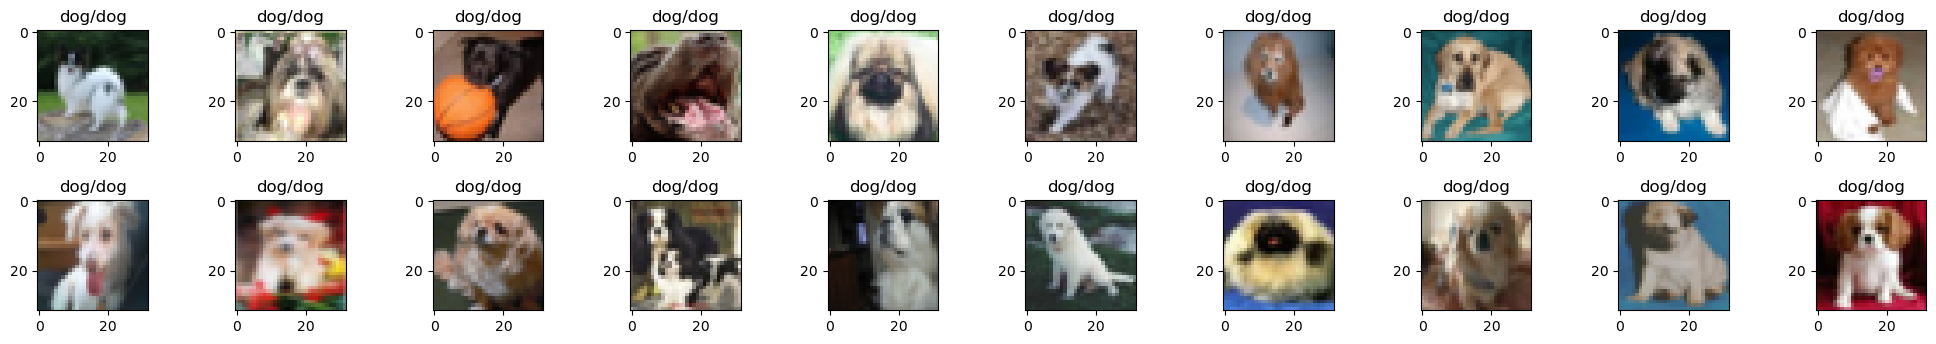

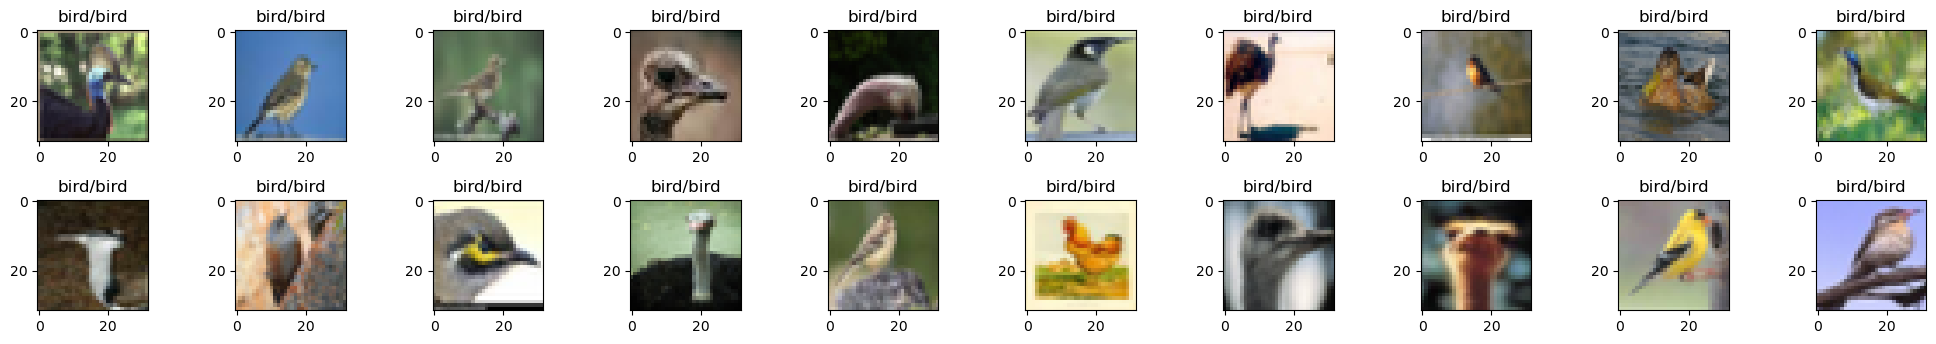

In [15]:
# observe dog-bird missclass
plot_image_compare(5, 2)

It also is hard to understand clearly why model made such prediction, but there are some thoughts (in brackets will be idea that can help to solve problem):
- most of well predicted birds have background as big part of the image, the same as bad predicted dogs, while well predicted take almoust all image (<b>image cropping/zooming</b>)
- it also seems that dogs and birds have same color pallete, so that can be missclassified (<b>color/brightness shift)

The image title has such structure: TRUE label/PRED label


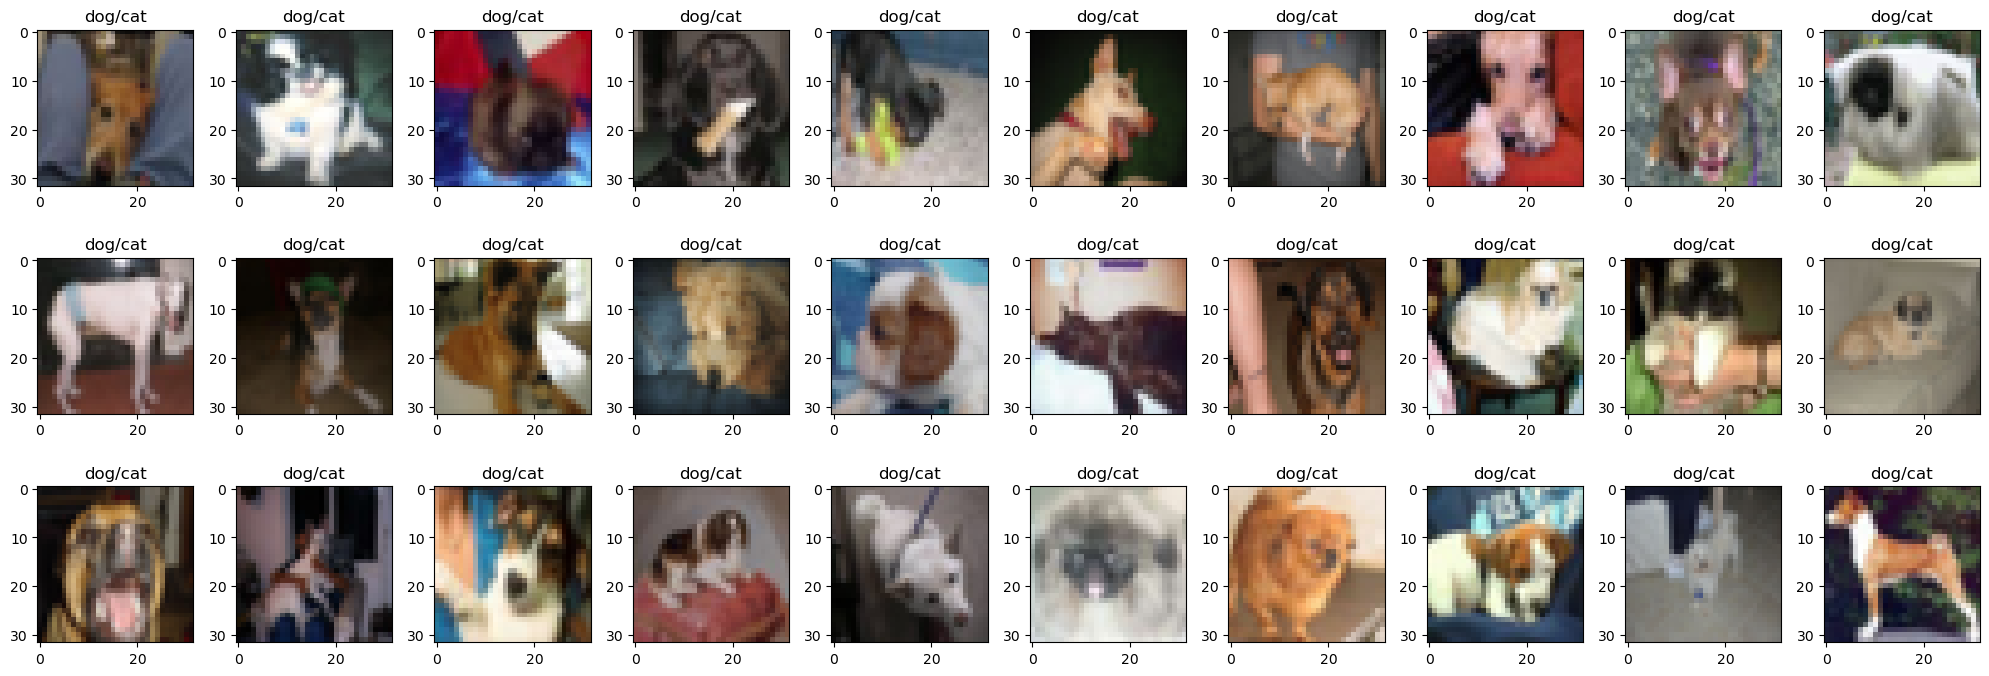

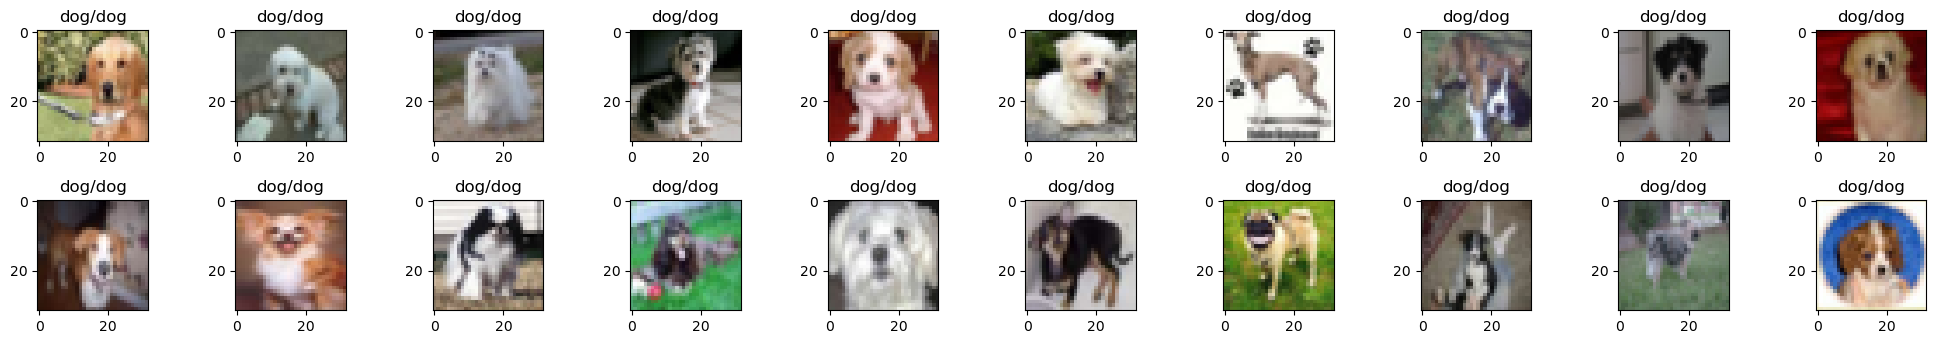

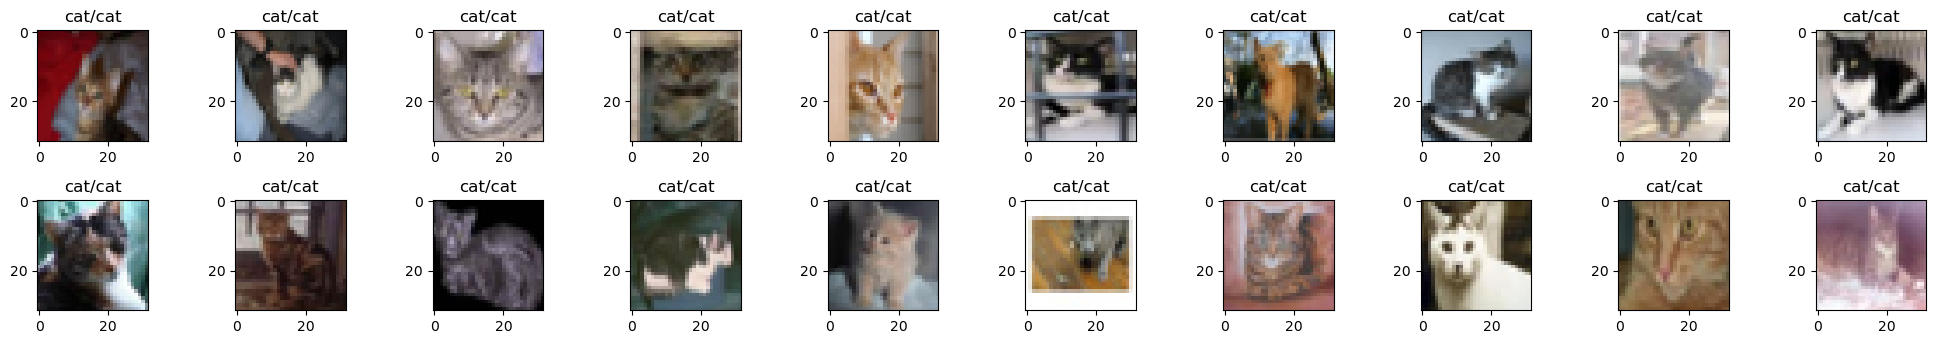

In [16]:
# observe dog-cat missclass
plot_image_compare(5, 3)

Cats and dogs at all look similar, and it is hard to distinguesh them properly. To solve this we may try <b>to add to units in FC layers</b> to gain more features, that could help classify cats and dogs correctly.

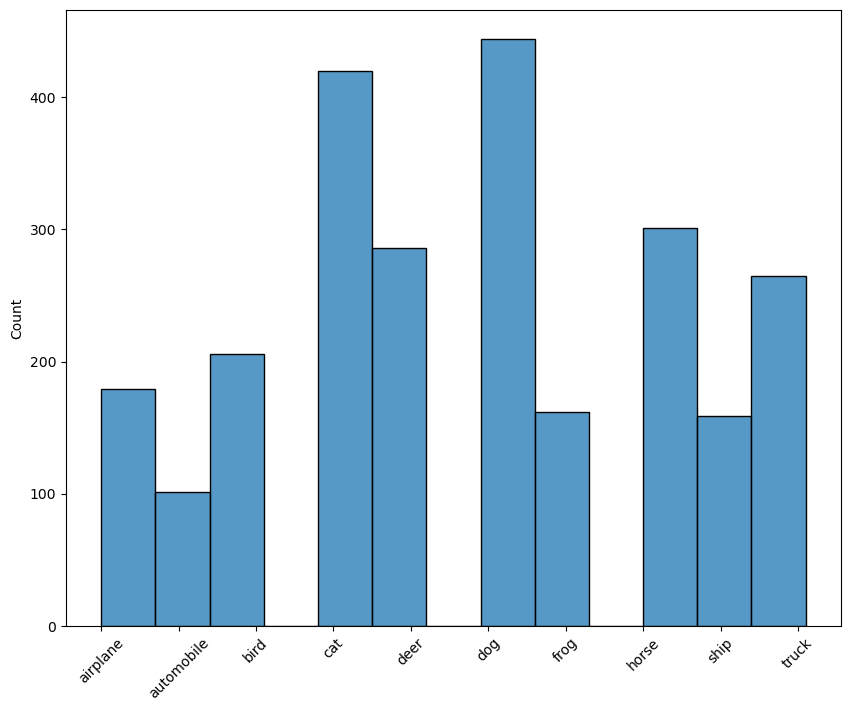

In [10]:
# plot N of error per each class
plt.figure(figsize=(10,8))
plt.xticks(range(10))
ax = sns.histplot(valid_y[valid_y != pred].numpy(), binwidth=0.7)
ax.set_xticklabels(label.values(), rotation=45)
plt.show()

Here we can see again why we choose 'cat' and 'dog' class as main problem, as in this place model made the most mistakes. If it will be able to improve perfomance in this area, we will get more balanced model amoung class prediction. Of course we will still have some problems, but them will be available to observate further.

## Data augmentaiton
As we remmember, later we made assumption, that some data preprocessing may increase our model accuracy and help to recognize some difficult classes. First of all we wanted to add some color shifting and brightness shifing. Also we wanted to made some image cropping. As all our objects on images are centered, zooming will be enought. Nevertheless, some usual parameters for data augmentation also added.

In [6]:
# create image augmentation generator
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #brightness_range=(0.65, 1.15),
    #zoom_range=0.2,
    #channel_shift_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

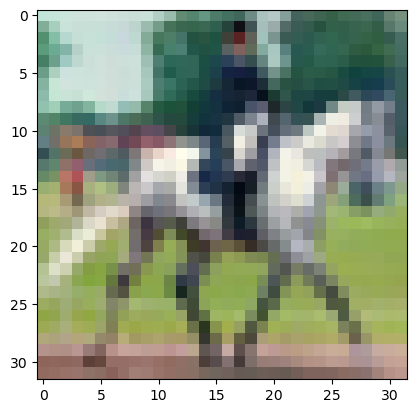

In [108]:
# choosing image for example
image = np.expand_dims(plt.imread('train/horse/10042.png'), 0)
plt.imshow(image[0])

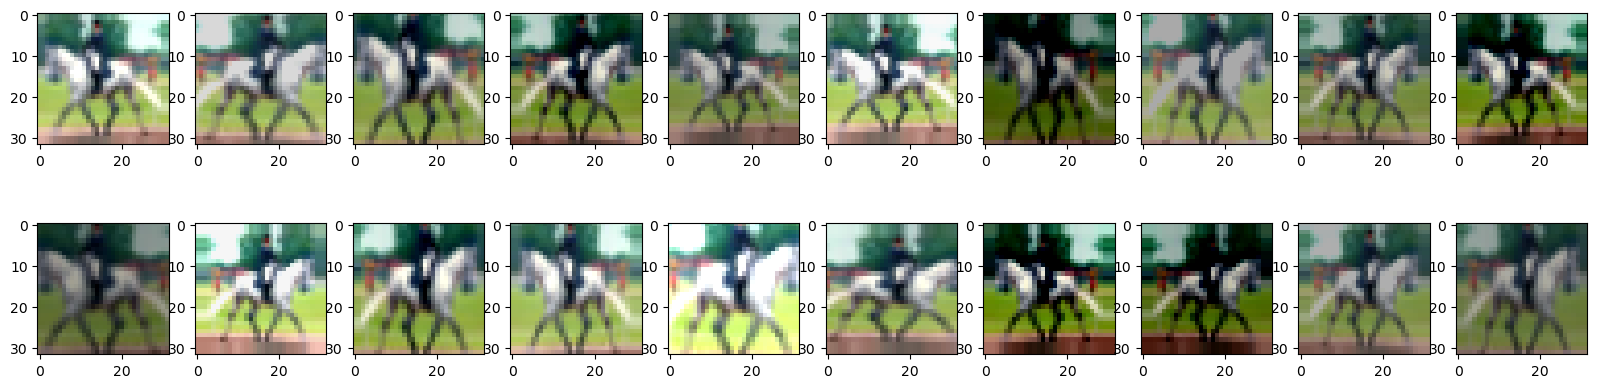

In [111]:
# augment image
aut_iter = data_aug.flow(image)

# plot 20 possible image augmentations
fig = plt.figure(figsize=(20,5))
for i, el in enumerate(aut_iter):
    if i == 20:
        break
    fig.add_subplot(2, 10, i + 1)
    plt.imshow(el[0].astype(np.uint8)) 

In [7]:
# creating new augmented datasets
aug_train_ds = data_aug.flow_from_directory('train', target_size=(32,32), batch_size=BATCH_SIZE, seed=42, subset='training')
aug_valid_ds = data_aug.flow_from_directory('train', target_size=(32,32), batch_size=BATCH_SIZE, seed=42, subset='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


Now let's try now our new augmeted data on first model and figure out whether there is some improvement.

In [ ]:
# build model again
model = first_model()
# compile model using Adam optimizer and CategoricalCrossentropy as loss
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(64, 32, 32, 3)]         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (64, 32, 32, 32)          896       
_________________________________________________________________
batch_normalization_42 (Batc (64, 32, 32, 32)          128       
_________________________________________________________________
conv2d_37 (Conv2D)           (64, 32, 32, 32)          9248      
_________________________________________________________________
batch_normalization_43 (Batc (64, 32, 32, 32)          128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (64, 16, 16, 32)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (64, 16, 16, 64)          1849

In [116]:
# add ModelCheckpoint to callback, so we can save and use the best model later
callbacks = [ModelCheckpoint('model/aug_model.h5', verbose=2, save_only_best=True, monitor='val_accuracy', mode='max')]

# train our model with 100 epochs
history = model.fit(aug_train_ds, epochs=EPOCHS, verbose=2, batch_size=BATCH_SIZE, validation_data=aug_valid_ds, callbacks=callbacks)

Epoch 1/100
625/625 - 60s - loss: 6.3501 - accuracy: 0.4418 - val_loss: 3.0741 - val_accuracy: 0.4748

Epoch 00001: saving model to model/aug_model.h5
Epoch 2/100
625/625 - 56s - loss: 2.2578 - accuracy: 0.5877 - val_loss: 2.0517 - val_accuracy: 0.5606

Epoch 00002: saving model to model/aug_model.h5
Epoch 3/100
625/625 - 56s - loss: 1.8303 - accuracy: 0.6389 - val_loss: 1.8630 - val_accuracy: 0.6189

Epoch 00003: saving model to model/aug_model.h5
Epoch 4/100
625/625 - 56s - loss: 1.7736 - accuracy: 0.6541 - val_loss: 1.8293 - val_accuracy: 0.6282

Epoch 00004: saving model to model/aug_model.h5
Epoch 5/100
625/625 - 56s - loss: 1.7387 - accuracy: 0.6687 - val_loss: 2.0104 - val_accuracy: 0.5674

Epoch 00005: saving model to model/aug_model.h5
Epoch 6/100
625/625 - 56s - loss: 1.7174 - accuracy: 0.6788 - val_loss: 2.0681 - val_accuracy: 0.5636

Epoch 00006: saving model to model/aug_model.h5
Epoch 7/100
625/625 - 56s - loss: 1.7037 - accuracy: 0.6852 - val_loss: 1.8574 - val_accuracy:

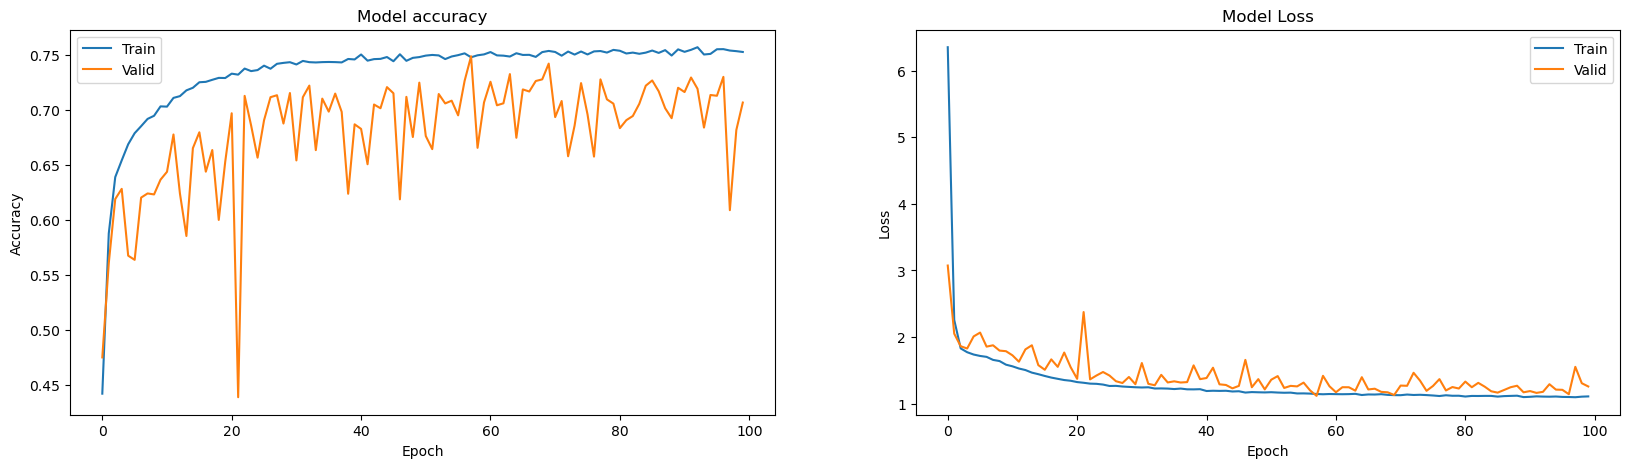

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot training & validation learning curve
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Valid'])

# Plot training & validation loss scores
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Valid'])

Cannot observe any improvements. 

Let's try some more complex deeper model
Another our assumption was that model is too simple. So to solve this let's try some transfer learning on already pretrained big model like ResNet50 to check if it brings some essntial improvements. We will be use weights from ImageNet, also we keep Conv layer's weights frooze and add some custom FC layers to adapt for out problem.

In [13]:
# load ResNet50 without top layers
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))

# prevent conv layers from learning
for layer in resnet.layers:
    layer.trainable = False

# add two FC layers to the end    
X = tf.keras.layers.Flatten()(resnet.output)
X = tf.keras.layers.Dense(1000, activation='relu')(X)
outputs = tf.keras.layers.Dense(10, activation = 'softmax')(X)

# join our model parts
transfer_model = tf.keras.Model(inputs = resnet.input, outputs = outputs)
# compile our pretrained model
transfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
transfer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
# add ModelCheckpoint to callback, so we can save and use the best model later
callbacks = [ModelCheckpoint('model/transfer_model.h5', verbose=1, save_only_best=True, monitor='val_accuracy', mode='max')]

# train our model with 40 epochs
history = transfer_model.fit(aug_train_ds, batch_size=BATCH_SIZE, epochs=40, validation_data=aug_valid_ds, verbose=2, callbacks=callbacks)

Epoch 1/40
625/625 - 79s - loss: 1.4793 - accuracy: 0.5173 - val_loss: 1.2470 - val_accuracy: 0.5607

Epoch 00001: saving model to model/transfer_model.h5
Epoch 2/40
625/625 - 56s - loss: 1.1934 - accuracy: 0.5811 - val_loss: 1.2015 - val_accuracy: 0.5773

Epoch 00002: saving model to model/transfer_model.h5
Epoch 3/40
625/625 - 57s - loss: 1.1356 - accuracy: 0.5995 - val_loss: 1.1972 - val_accuracy: 0.5799

Epoch 00003: saving model to model/transfer_model.h5
Epoch 4/40
625/625 - 57s - loss: 1.1071 - accuracy: 0.6076 - val_loss: 1.1571 - val_accuracy: 0.5957

Epoch 00004: saving model to model/transfer_model.h5
Epoch 5/40
625/625 - 58s - loss: 1.0736 - accuracy: 0.6199 - val_loss: 1.1522 - val_accuracy: 0.6005

Epoch 00005: saving model to model/transfer_model.h5
Epoch 6/40
625/625 - 59s - loss: 1.0569 - accuracy: 0.6266 - val_loss: 1.1592 - val_accuracy: 0.6015

Epoch 00006: saving model to model/transfer_model.h5
Epoch 7/40
625/625 - 61s - loss: 1.0452 - accuracy: 0.6294 - val_loss:

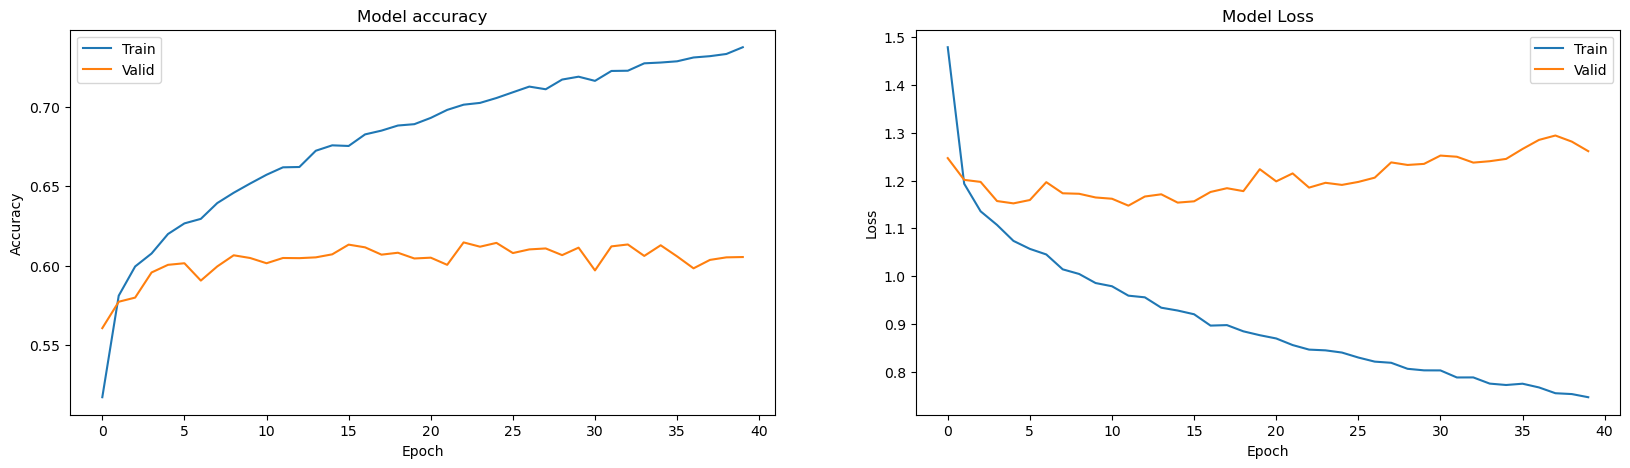

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot training & validation learning curve
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Valid'])

# Plot training & validation loss scores
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Valid'])

Blah, blah, blah, conclusions

In [6]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=tf.keras.optimizers.Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(32,32,3),padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(tf.keras.layers.Dropout(drop_conv))

model.add(tf.keras.layers.Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(tf.keras.layers.Dropout(drop_conv))

model.add(tf.keras.layers.Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(tf.keras.layers.Dropout(drop_conv))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation=ac,kernel_regularizer=reg))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(drop_dense))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

callbacks = [ModelCheckpoint('not_my.h5', verbose=1, save_only_best=True, monitor='val_accuracy', mode='max')]

history = model.fit(train_ds, batch_size=64, epochs=40, validation_data=valid_ds, verbose=2, callbacks=callbacks)

Epoch 1/40


2022-11-06 15:22:06.269289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-06 15:22:06.274990: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400500000 Hz
2022-11-06 15:22:06.587930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-06 15:22:07.044914: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-06 15:22:08.699638: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-06 15:22:08.735414: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


625/625 - 22s - loss: 1.5385 - accuracy: 0.4936 - val_loss: 1.1172 - val_accuracy: 0.6096

Epoch 00001: saving model to not_my.h5
Epoch 2/40
625/625 - 8s - loss: 0.9458 - accuracy: 0.6693 - val_loss: 0.8167 - val_accuracy: 0.7120

Epoch 00002: saving model to not_my.h5
Epoch 3/40
625/625 - 8s - loss: 0.7295 - accuracy: 0.7461 - val_loss: 0.8008 - val_accuracy: 0.7214

Epoch 00003: saving model to not_my.h5
Epoch 4/40
625/625 - 8s - loss: 0.6138 - accuracy: 0.7861 - val_loss: 0.7842 - val_accuracy: 0.7316

Epoch 00004: saving model to not_my.h5
Epoch 5/40
625/625 - 8s - loss: 0.5167 - accuracy: 0.8195 - val_loss: 0.6918 - val_accuracy: 0.7626

Epoch 00005: saving model to not_my.h5
Epoch 6/40
625/625 - 8s - loss: 0.4384 - accuracy: 0.8476 - val_loss: 0.7990 - val_accuracy: 0.7441

Epoch 00006: saving model to not_my.h5
Epoch 7/40
625/625 - 8s - loss: 0.3655 - accuracy: 0.8724 - val_loss: 0.7268 - val_accuracy: 0.7738

Epoch 00007: saving model to not_my.h5
Epoch 8/40
625/625 - 8s - loss

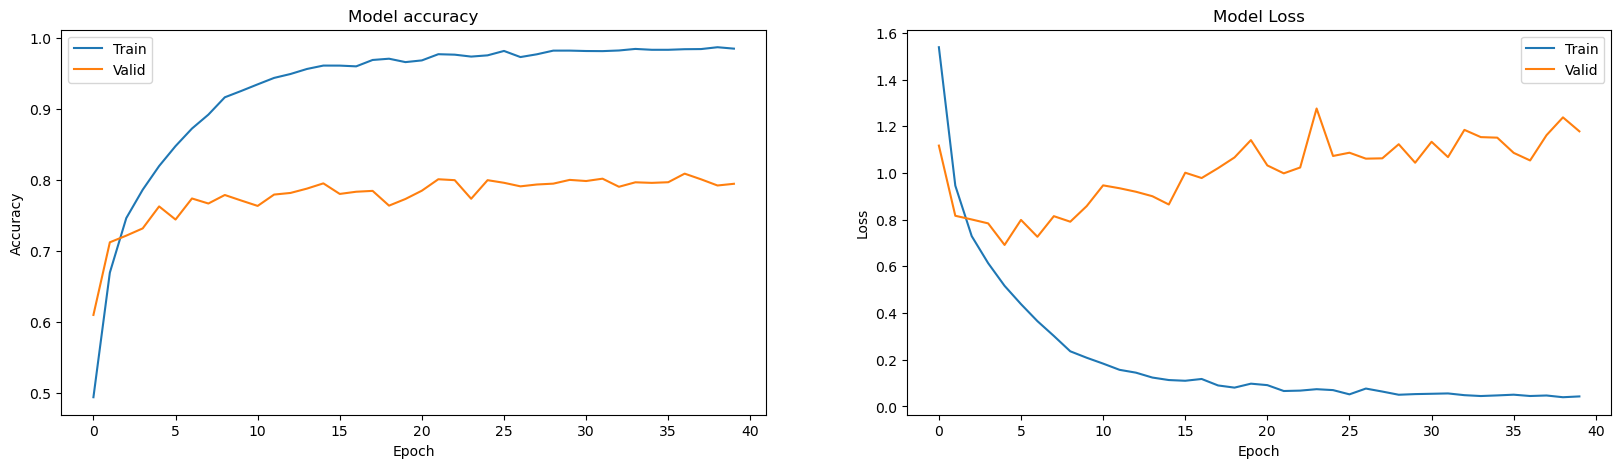

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot training & validation learning curve
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Valid'])

# Plot training & validation loss scores
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Valid'])

In [66]:
model = tf.keras.models.load_model('not_my.h5')

In [7]:
valid_X = []
valid_y = []
for x, y in valid_ds:
    valid_X.append(x)
    valid_y.append(y)

2022-11-06 15:38:17.793068: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-06 15:38:17.794831: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400500000 Hz


In [9]:
valid_X = tf.concat(valid_X, axis=0)
valid_y = tf.concat(valid_y, axis=0)    # true values

# make model prediction
pred = np.argmax(model.predict(valid_X), axis=1)

2022-11-06 15:40:39.106240: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-11-06 15:40:39.293065: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-06 15:40:39.781613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-06 15:40:41.548347: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-06 15:40:41.594526: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [77]:
lbls = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [70]:
pred = np.argmax(model.predict(test_ds), axis=1)

In [86]:
answ = pd.DataFrame([lbls[el] for el in pred], columns=['label'])
answ.index = np.arange(1, answ.shape[0] + 1)
answ.index.name = 'id'
answ.to_csv('answ.csv')

(array([6.4724e+04, 9.7326e+04, 6.9000e+02, 1.9780e+03, 4.0000e+00,
        1.9606e+04, 0.0000e+00, 9.0163e+04, 4.5710e+03, 2.0938e+04]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

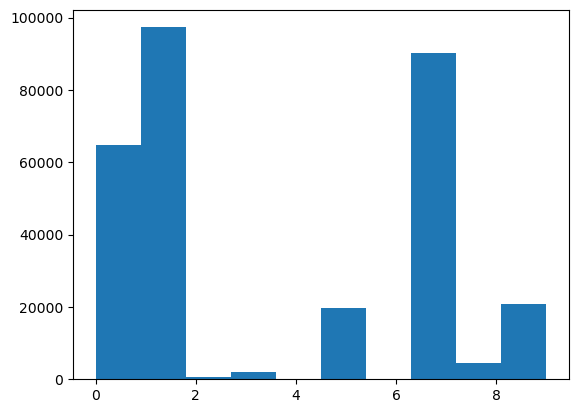

In [71]:
plt.hist(pred)

In [17]:
np.argmax(pred,axis=1)

array([8, 8, 0, ..., 8, 7, 3])

In [68]:
def read_test_image(path_to_image):
    img = tf.io.read_file('test_new/' + path_to_image)
    img = tf.image.decode_image(img, channels=3,dtype=tf.int32)
    return img

In [69]:
test_path = 'test'
test_files_path = os.listdir(test_path)

test_ds = tf.data.Dataset.from_tensor_slices(test_files_path)
test_ds = test_ds.map(read_test_image)
test_ds = test_ds.batch(64)

In [4]:
model = tf.keras.models.load_model('model/model.h5')

In [13]:
pred = model.predict(valid_ds)

In [14]:
model.evaluate(valid_ds)

157/157 [==============================] - 8s 42ms/step - loss: 1.1459 - accuracy: 0.7441


[1.145857334136963, 0.7441281676292419]

(array([1129., 1074., 1453.,  987.,  998.,  788., 1021.,  845.,  907.,
         798.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

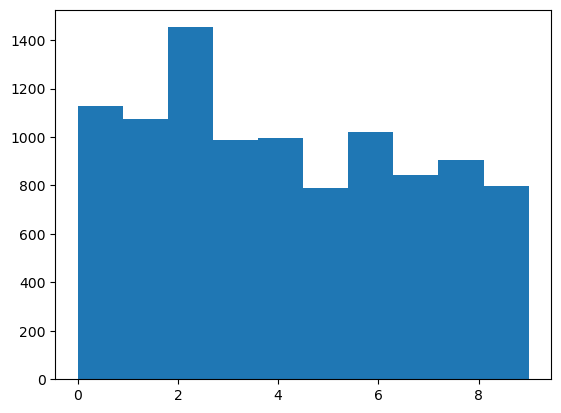

In [15]:
plt.hist(np.argmax(pred, axis=1))

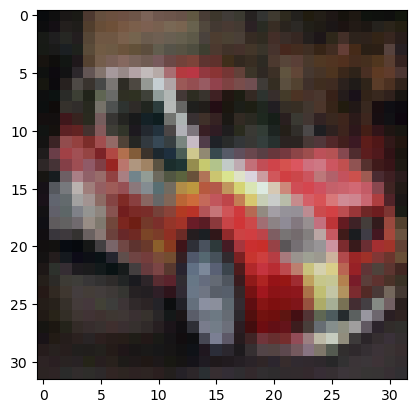

In [51]:
for i, el in enumerate(test_ds):
    if i == 22:
        plt.imshow(el[0])
        break

In [54]:
pred[:10]

array([[0.05532984, 0.00265553, 0.21948119, 0.12809804, 0.48392206,
        0.01017481, 0.07590732, 0.00922495, 0.01216605, 0.00304011],
       [0.05374616, 0.00266605, 0.21512586, 0.12821257, 0.48986426,
        0.01015684, 0.07585925, 0.00931211, 0.01202993, 0.00302694],
       [0.05398155, 0.00263916, 0.21536343, 0.12667798, 0.49184826,
        0.01031283, 0.07469845, 0.00944332, 0.0120524 , 0.00298257],
       [0.05111331, 0.00265972, 0.2121347 , 0.12736209, 0.49553174,
        0.01013403, 0.07695673, 0.00930665, 0.01173769, 0.00306338],
       [0.05264997, 0.00265584, 0.21574673, 0.12682416, 0.49308866,
        0.01028892, 0.074732  , 0.00920659, 0.01182188, 0.00298528],
       [0.05403502, 0.00269251, 0.21873118, 0.12542807, 0.48902947,
        0.01010322, 0.0755046 , 0.00937749, 0.01209719, 0.00300123],
       [0.0532654 , 0.00259784, 0.21447274, 0.13036965, 0.488252  ,
        0.01028377, 0.07691152, 0.00905636, 0.01172835, 0.00306243],
       [0.0538471 , 0.00268193, 0.2159058

In [90]:
tf.keras.models.save_model(model, 'temp', save_format='h5')

In [12]:
#first_m = tf.keras.models.load_model(MODEL_PATH)
f_pred = first_m.predict(valid_ds)

NameError: name 'first_m' is not defined

In [79]:
first_m.evaluate(train_ds)

625/625 [==============================] - 10s 15ms/step - loss: 1.0072 - accuracy: 0.7950


[1.007154107093811, 0.7950249910354614]

(array([     0.,      0.,      0.,      0.,      0., 300000.,      0.,
             0.,      0.,      0.]),
 array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5]),
 <BarContainer object of 10 artists>)

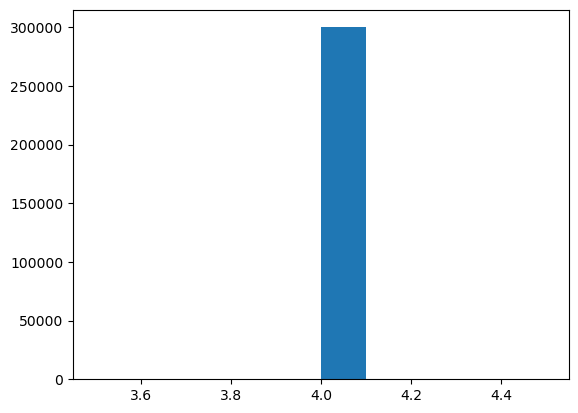

In [85]:
plt.hist(np.argmax(f_pred, axis=1))

In [86]:
f_pred[:5]

array([[0.09094863, 0.0005754 , 0.22988008, 0.06318084, 0.4926083 ,
        0.00842325, 0.09624811, 0.00160288, 0.01600527, 0.00052723],
       [0.09149624, 0.00057739, 0.2302629 , 0.06284989, 0.49208498,
        0.00839368, 0.09611267, 0.00160282, 0.01609081, 0.00052858],
       [0.09133108, 0.00057483, 0.2299575 , 0.0633476 , 0.49182063,
        0.00841746, 0.09639508, 0.00159855, 0.01603131, 0.00052601],
       [0.09113894, 0.0005763 , 0.23057367, 0.06318983, 0.4912221 ,
        0.0084409 , 0.09668586, 0.00161169, 0.01603113, 0.00052961],
       [0.09079613, 0.00057348, 0.22964196, 0.06317285, 0.4930919 ,
        0.00840729, 0.09618466, 0.001604  , 0.01600074, 0.00052694]],
      dtype=float32)

In [87]:
np.argmax(f_pred, axis=1)

array([4, 4, 4, ..., 4, 4, 4])